In [1]:
# Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# LOAD & EXPLORE DATA

# ---- Load the dataset ----

df = pd.read_csv("personalised_dataset.csv")  
print("Shape of dataset:", df.shape)
print("\nColumn names:", df.columns.tolist())

# ---- View the dataset ----
print("\nFirst 5 rows:")
print(df.head())

# ---- Check for missing values ----
print("\nMissing values per column:")
print(df.isnull().sum())

# ---- Basic descriptive stats ----
print("\nDescriptive statistics:")
print(df.describe(include='all'))

# ---- Check data types ----
print("\nData Types:")
print(df.dtypes)

Shape of dataset: (2000, 40)

Column names: ['Patient_ID', 'Age', 'Gender', 'BMI', 'Smoking_Status', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Diet_Type', 'Blood_Pressure', 'Cholesterol', 'Glucose_Level', 'HbA1c', 'Heart_Disease_Risk', 'Diabetes_Risk', 'Health_Risk', 'Predicted_Insurance_Cost', 'Diet_Recommendation', 'Exercise_Recommendation', 'PRS_Cardiometabolic', 'PRS_Type2Diabetes', 'APOE_e4_Carrier', 'BRCA_Pathogenic_Variant', 'Family_History_CVD', 'Family_History_T2D', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Social_Isolation_Index', 'Sleep_Hours', 'Sleep_Quality', 'Resting_Heart_Rate', 'HRV', 'Systolic_BP', 'Diastolic_BP', 'LDL', 'HDL', 'Triglycerides', 'CRP', 'eGFR', 'Waist_Circumference']

First 5 rows:
   Patient_ID  Age  Gender   BMI  Smoking_Status Alcohol_Consumption  \
0           1   55    Male  26.0  Current smoker                 NaN   
1           2   33    Male  29.5      Non-smoker                 Low   
2           3   62  Female  31.3      No

<Figure size 1200x600 with 0 Axes>

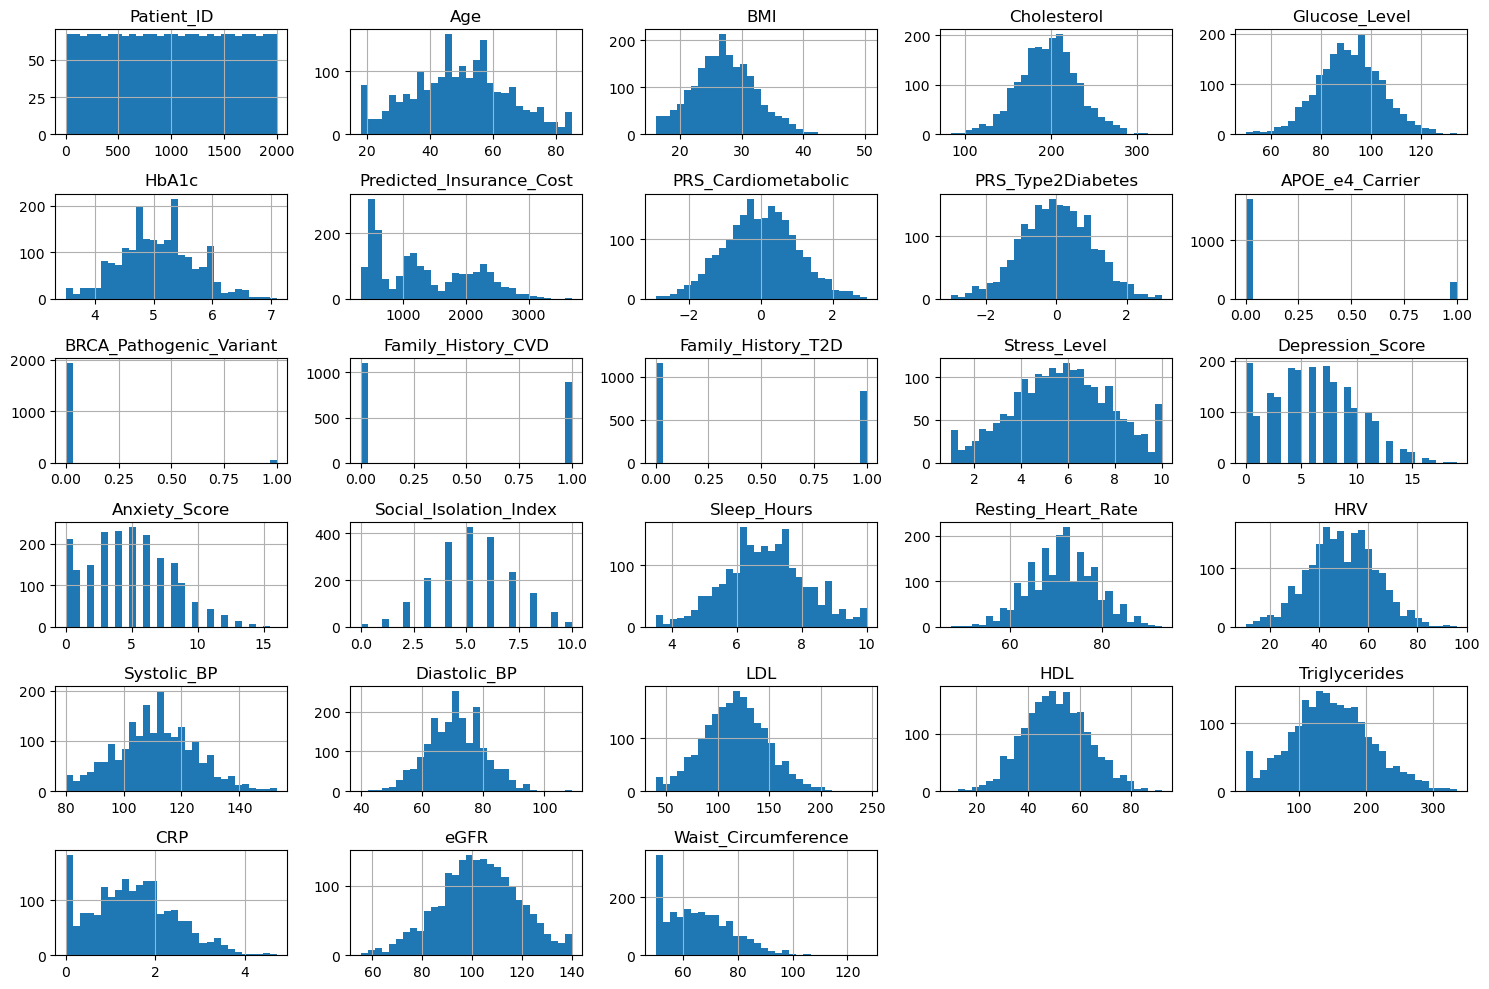

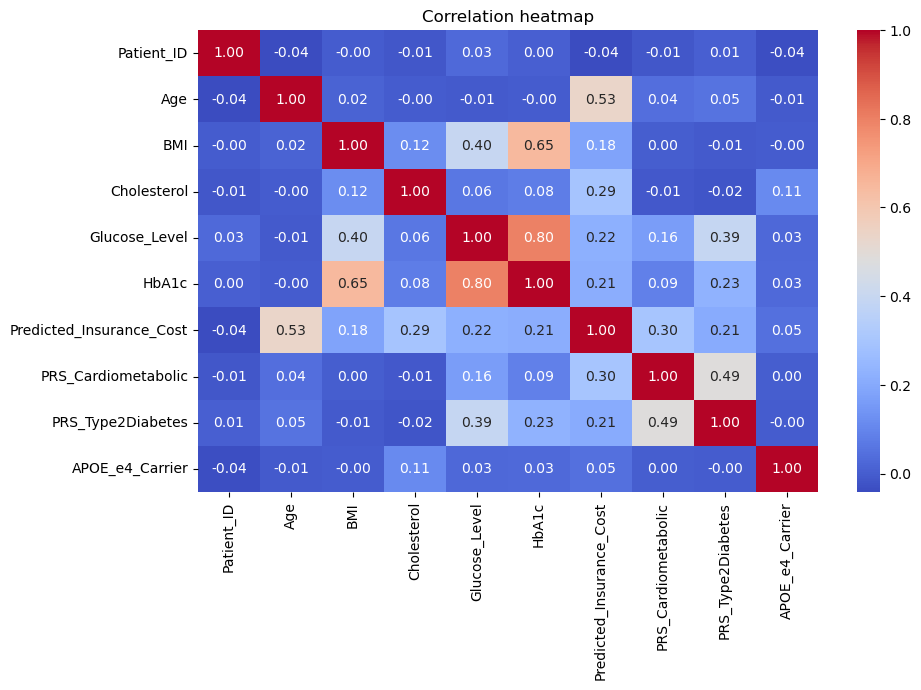

In [4]:
# ---- Visualize numeric columns ----
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 6))
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()

plt.savefig('charts/Histograms.png')
plt.show()

# ---- Visualize correlations ----
plt.figure(figsize=(10, 6))

# Calculate correlation matrix for numeric columns
subset = numeric_cols[:10]  
sns.heatmap(df[subset].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation heatmap")

plt.savefig('charts/Heatmap.png')
plt.show()

In [5]:
# STEP 2: DATA PREPROCESSING
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ----- 1. Identify categorical & numeric columns -----
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Columns:", categorical_cols)
print("Numeric Columns:", numeric_cols)

# ----- 2. Handle missing values -----
# Fill numeric columns with median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# ----- 3. Define X (features) and y (target) -----

target = "Health_Risk"  
X = df.drop(columns=[target])
y = df[target]

# ----- 4. Column transformer for preprocessing -----
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numeric features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# ----- 5. Split data -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Categorical Columns: ['Gender', 'Smoking_Status', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Diet_Type', 'Blood_Pressure', 'Heart_Disease_Risk', 'Diabetes_Risk', 'Health_Risk', 'Diet_Recommendation', 'Exercise_Recommendation', 'Sleep_Quality']
Numeric Columns: ['Patient_ID', 'Age', 'BMI', 'Cholesterol', 'Glucose_Level', 'HbA1c', 'Predicted_Insurance_Cost', 'PRS_Cardiometabolic', 'PRS_Type2Diabetes', 'APOE_e4_Carrier', 'BRCA_Pathogenic_Variant', 'Family_History_CVD', 'Family_History_T2D', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Social_Isolation_Index', 'Sleep_Hours', 'Resting_Heart_Rate', 'HRV', 'Systolic_BP', 'Diastolic_BP', 'LDL', 'HDL', 'Triglycerides', 'CRP', 'eGFR', 'Waist_Circumference']
Training set shape: (1600, 39)
Test set shape: (400, 39)


In [8]:
# STEP 3: FEATURE ENGINEERING & SELECTION (FIXED)

from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# ---- 1. Separate X and y ----
target = "Health_Risk"  
X = df.drop(columns=[target])
y = df[target]

# ---- 2. Recalculate numeric and categorical columns from X only ----
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# ---- 3. Preprocess X ----
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_transformed = preprocessor.fit_transform(X)

# ---- 4. Convert transformed features to DataFrame ----
encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + encoded_cols.tolist()
X_df = pd.DataFrame(
    X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed,
    columns=all_feature_names
)

# ---- 5. Feature Selection ----
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_df, y)
selected_features = X_df.columns[selector.get_support()]

print("\nTop 10 selected features:")
print(selected_features)


Top 10 selected features:
Index(['Age', 'Predicted_Insurance_Cost', 'Heart_Disease_Risk_High',
       'Heart_Disease_Risk_Low', 'Heart_Disease_Risk_Moderate',
       'Diet_Recommendation_Balanced whole-food diet.',
       'Diet_Recommendation_Mediterranean, reduce sat fat & sodium.',
       'Exercise_Recommendation_150+ min moderate cardio + 2x strength/wk; start gradual.',
       'Exercise_Recommendation_Maintain 90+ min mixed activity; add HIIT if cleared.',
       'Exercise_Recommendation_≥120 min cardio + weekly strength & mobility.'],
      dtype='object')


C:\Users\NAILA\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


----- Logistic Regression -----
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       125
         Low       1.00      1.00      1.00       162
    Moderate       1.00      1.00      1.00       113

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



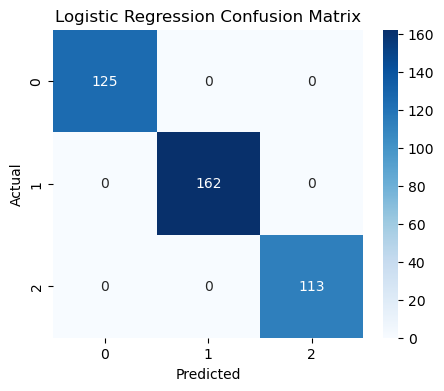


----- Random Forest -----
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       125
         Low       1.00      1.00      1.00       162
    Moderate       1.00      1.00      1.00       113

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



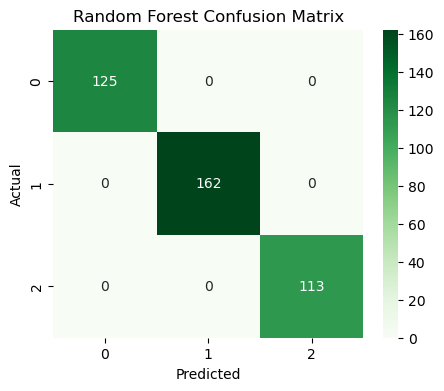

In [9]:
# STEP 4: MODEL TRAINING & EVALUATION
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Split the selected features into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_df[selected_features], y, test_size=0.2, random_state=42, stratify=y
)

# --- 1. Logistic Regression ---
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("----- Logistic Regression -----")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lr, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion matrix for Logistic Regression
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig('charts/Logistic_regression.png')
plt.show()

# --- 2. Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n----- Random Forest -----")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix for Random Forest
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig('charts/Random_forest.png')
plt.show()

LogisticRegression CV Accuracy: 1.000 (+/- 0.000)
RandomForestClassifier CV Accuracy: 1.000 (+/- 0.000)


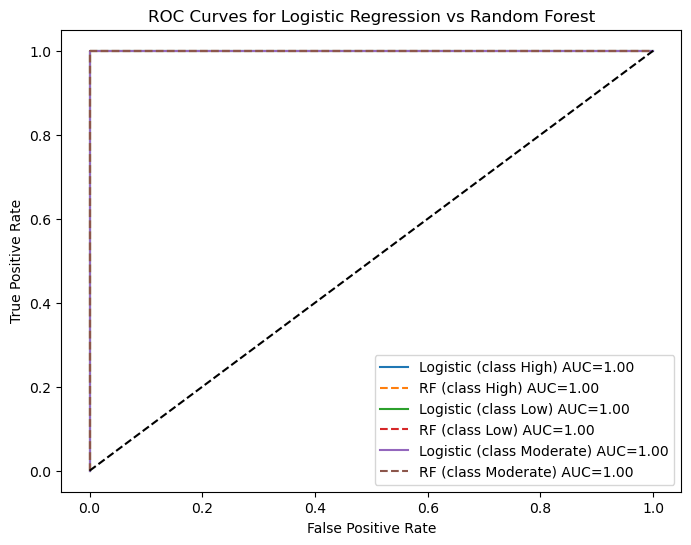

In [10]:
# STEP 5: MODEL EVALUATION WITH CROSS-VALIDATION + ROC CURVES
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import numpy as np

# --- 1. Cross-Validation Scores ---
def evaluate_cv(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{model.__class__.__name__} CV Accuracy: {scores.mean():.3f} (+/- {scores.std():.3f})")
    return scores

evaluate_cv(log_reg, X_df[selected_features], y)
evaluate_cv(rf, X_df[selected_features], y)

# --- 2. ROC Curve (One-vs-Rest for multi-class) ---
# Binarize y for ROC calculation
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)

# Train models for ROC
log_reg_ovr = OneVsRestClassifier(log_reg)
rf_ovr = OneVsRestClassifier(rf)

log_reg_ovr.fit(X_train, y_train)
rf_ovr.fit(X_train, y_train)

y_score_lr = log_reg_ovr.predict_proba(X_test)
y_score_rf = rf_ovr.predict_proba(X_test)

# --- Plot ROC curves for each class ---
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    fpr_lr, tpr_lr, _ = roc_curve(label_binarize(y_test, classes=classes)[:, i], y_score_lr[:, i])
    fpr_rf, tpr_rf, _ = roc_curve(label_binarize(y_test, classes=classes)[:, i], y_score_rf[:, i])
    plt.plot(fpr_lr, tpr_lr, label=f"Logistic (class {class_label}) AUC={auc(fpr_lr, tpr_lr):.2f}")
    plt.plot(fpr_rf, tpr_rf, linestyle='--', label=f"RF (class {class_label}) AUC={auc(fpr_rf, tpr_rf):.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Logistic Regression vs Random Forest")
plt.legend(loc="lower right")

plt.savefig("charts/ROC_curves.png")
plt.show()


Top 10 Most Important Features (Random Forest):
Exercise_Recommendation_Maintain 90+ min mixed activity; add HIIT if cleared.: 0.2497
Exercise_Recommendation_≥120 min cardio + weekly strength & mobility.: 0.1969
Exercise_Recommendation_150+ min moderate cardio + 2x strength/wk; start gradual.: 0.1958
Heart_Disease_Risk_High: 0.1058
Heart_Disease_Risk_Low: 0.0988
Predicted_Insurance_Cost: 0.0797
Heart_Disease_Risk_Moderate: 0.0343
Diet_Recommendation_Mediterranean, reduce sat fat & sodium.: 0.0342
Diet_Recommendation_Balanced whole-food diet.: 0.0025
Age: 0.0024


C:\Users\NAILA\AppData\Local\Temp\ipykernel_30888\668292503.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='coolwarm')


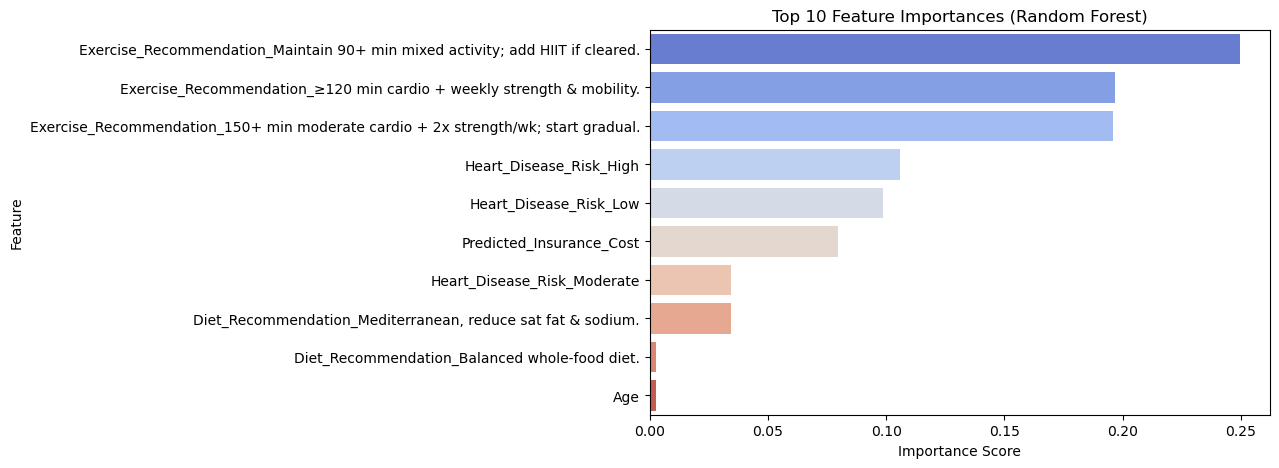

In [11]:
# STEP 6: FEATURE IMPORTANCE FROM RANDOM FOREST
import numpy as np

# Train RF again on the full training set
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 10 features
top_features = [selected_features[i] for i in indices[:10]]
top_importances = importances[indices[:10]]

# Print
print("\nTop 10 Most Important Features (Random Forest):")
for f, imp in zip(top_features, top_importances):
    print(f"{f}: {imp:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=top_importances, y=top_features, palette='coolwarm')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plt.savefig("charts/Top_features_RF.png")
plt.show()

----- XGBoost -----
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00       162
           2       1.00      1.00      1.00       113

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



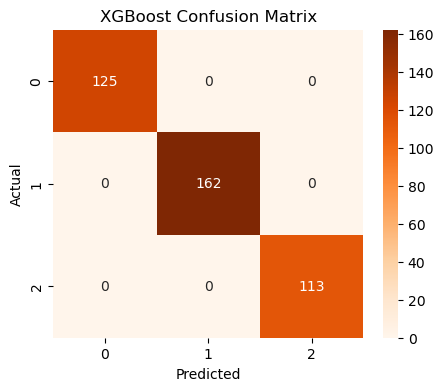

In [13]:
# STEP 7: TRAIN XGBOOST CLASSIFIER
from sklearn.preprocessing import LabelEncoder

# Encode y into numeric labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split with encoded y
X_train, X_test, y_train, y_test = train_test_split(
    X_df[selected_features], y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

from xgboost import XGBClassifier

# Train
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print("----- XGBoost -----")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig("charts/XGBooster.png")
plt.show()

In [22]:
# STEP 8: Personalized Healthcare Recommendations

def generate_recommendations(prediction, row):
    """
    Generate personalized healthcare recommendations based on the predicted risk level.
    """
    recs = []
    
    if prediction == "High":
        recs.append("⚠️ High health risk detected! Consult a healthcare professional.")
        recs.append("Increase physical activity to at least 30 mins/day.")
        recs.append("Adopt a balanced, low-sugar diet with high fiber.")
        recs.append("Schedule regular health check-ups.")
    
    elif prediction == "Moderate":
        recs.append("⚠️ Moderate health risk. Consider lifestyle adjustments.")
        recs.append("Start moderate exercise 3–4 times a week.")
        recs.append("Monitor your diet and reduce processed foods.")
        recs.append("Keep track of health indicators like BP & glucose.")
    
    else:  # Low
        recs.append("✅ Low health risk. Keep up the healthy habits!")
        recs.append("Continue regular exercise and balanced diet.")
        recs.append("Get yearly check-ups to maintain your health.")
    
    return recs

# Example: Generate recommendations for a test sample
sample = X_test.iloc[10]  # Pick a random row
sample_pred = rf.predict([sample])[0]  # Predict risk
print(f"Predicted Risk: {sample_pred}")
print("Personalized Recommendations:")
for r in generate_recommendations(sample_pred, sample):
    print("-", r)

Predicted Risk: Low
Personalized Recommendations:
- ✅ Low health risk. Keep up the healthy habits!
- Continue regular exercise and balanced diet.
- Get yearly check-ups to maintain your health.


C:\Users\NAILA\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
